In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [3]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
#proposal_probs = {"multi_grow": 0.5, "multi_prune": 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
n_chains = 4
chains = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=50, nskip=50, n_trees=100, proposal_probs=proposal_probs, multi_tries=[10,5], random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.044


MultiGrow ratio count: 2554
MultiPrune ratio count: 2219
MultiChange ratio count: 3716
MultiSwap ratio count: 256


C:\Windows\Temp\ipykernel_11076\3590833088.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


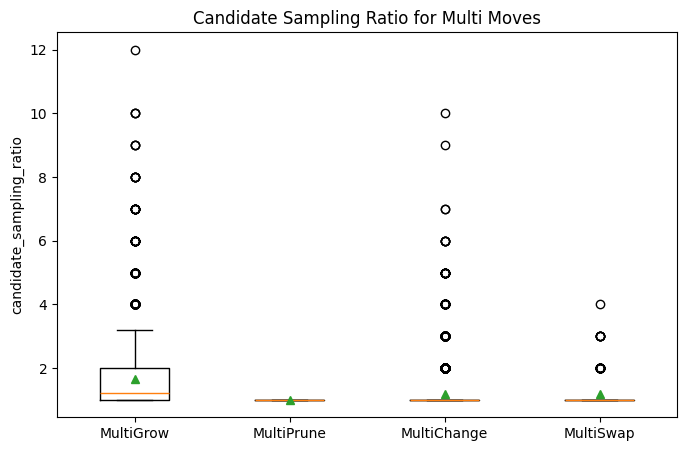

In [5]:
import matplotlib.pyplot as plt

# Collect ratios for all four Multi moves
grow_ratios = np.array(bart.sampler.multi_ratios["multigrow"])
prune_ratios = np.array(bart.sampler.multi_ratios["multiprune"])
change_ratios = np.array(bart.sampler.multi_ratios["multichange"])
swap_ratios = np.array(bart.sampler.multi_ratios["multiswap"])

# Print the number of samples for each move
print(f"MultiGrow ratio count: {len(grow_ratios)}")
print(f"MultiPrune ratio count: {len(prune_ratios)}")
print(f"MultiChange ratio count: {len(change_ratios)}")
print(f"MultiSwap ratio count: {len(swap_ratios)}")

# Combine for boxplot
data = [grow_ratios, prune_ratios, change_ratios, swap_ratios]
labels = ["MultiGrow", "MultiPrune", "MultiChange", "MultiSwap"]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels, showmeans=True)
plt.ylabel("candidate_sampling_ratio")
plt.title("Candidate Sampling Ratio for Multi Moves")
plt.show()

In [6]:
import pandas as pd

# Collect move counts
selected = bart.sampler.move_selected_counts
success = bart.sampler.move_success_counts
accepted = bart.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

              selected  success  accepted  success_rate  mh_ratio  accept_rate
multi_grow        2554     2554      1136      1.000000  0.444792     0.444792
multi_prune       2415     2219       971      0.918841  0.437584     0.402070
multi_change      4062     3716      2653      0.914820  0.713940     0.653127
multi_swap         969      256       175      0.264190  0.683594     0.180599


In [7]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=50, nskip=50)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-06-24 00:19:01,749:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-24 00:19:01,753:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/100 P_grow=0.55 P_prune=0.45 A_grow=0.36 A_prune=0.36


In [8]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.023476736906297535,
 'rf': 0.022139023845392215,
 'lr': 0.048045521328019404,
 'btz': 0.025420090867930605}

## Default BART

In [9]:
# bart = DefaultBART(ndpost=50, nskip=0, n_trees=100, proposal_probs=proposal_probs)
# bart.fit(X_train, y_train)

In [10]:
n_chains = 4
chains = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart = DefaultBART(ndpost=50, nskip=50, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 100/100 [00:03<00:00, 31.19it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.158


In [11]:
import pandas as pd

# Collect move counts
selected = bart.sampler.move_selected_counts
success = bart.sampler.move_success_counts
accepted = bart.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

        selected  success  accepted  success_rate  mh_ratio  accept_rate
grow        2526     2526      1070      1.000000  0.423595     0.423595
prune       2467     2243       906      0.909201  0.403923     0.367248
change      3951     3565      2178      0.902303  0.610940     0.551253
swap        1056      277       177      0.262311  0.638989     0.167614


In [12]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.022884105195323252,
 'rf': 0.022139023845392215,
 'lr': 0.048045521328019404,
 'btz': 0.025420090867930605}